In [1]:
import torch
from torch.utils.data import DataLoader
from models.cvae.feature_extraction import extract_features
from models.cvae.cvae import get_model
import os
import cv2
import shutil
import numpy as np
from modules.dataset import SignatureFigDataset
import yaml
import random
from modules.clustering_utils import find_optimal_clusters, plot_results, analyze_clusters
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
with open("config/config.yaml", "r") as f:
    try:
        config = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)
print(config)

seed = config['train_params']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)

{'model_params': {'in_channels': 1, 'convbn_blocks': 5, 'conv_kernel_size': [4, 4, 4, 4, 4], 'conv_kernel_strides': [2, 2, 2, 2, 2], 'conv_padding': [1, 1, 1, 1, 1], 'convbn_channels': [1, 32, 64, 128, 256, 512], 'enc_fc_layers': [32768, 4096, 512, 64, 16], 'enc_fc_mu_activation': 'leaky', 'enc_fc_var_activation': 'leaky', 'conv_activation_fn': 'leaky', 'enc_fc_activation_fn': 'leaky', 'dec_fc_layers': [16, 64, 512, 4096, 32768], 'dec_fc_activation_fn': 'leaky', 'transpose_bn_blocks': 5, 'transposebn_channels': [512, 256, 128, 64, 32, 1], 'transpose_kernel_size': [4, 4, 4, 4, 4], 'transpose_kernel_strides': [2, 2, 2, 2, 2], 'transpose_padding': [1, 1, 1, 1, 1], 'transpose_activation_fn': 'tanh', 'log_variance': True, 'latent_dim': 16}, 'train_params': {'task_name': 'cvae_feature_extraction', 'batch_size': 8, 'epochs': 1000, 'kl_weight': 1e-05, 'lr': 0.0001, 'crit': 'l2', 'ckpt_name': 'best_cvae.pth', 'seed': 42, 'save_training_image': True, 'output_train_dir': 'output', 'save_latent_pl

In [3]:
# Data
signatures_fig_path = os.path.join("data", "a_fig")

if not os.path.exists(signatures_fig_path):
    raise FileNotFoundError(f"The directory {signatures_fig_path} does not exist.")

signature_figs = []
filenames = []  # New list to store filenames
for signature_fig_file in os.listdir(signatures_fig_path):
    # Store filename without extension
    filenames.append(os.path.splitext(signature_fig_file)[0])

    signature_fig_file_path = os.path.join(signatures_fig_path, signature_fig_file)
    signature_fig = cv2.imread(signature_fig_file_path, cv2.IMREAD_GRAYSCALE)
    signature_fig = signature_fig.reshape(1, *signature_fig.shape, 1)
    signature_figs.append(signature_fig)

signature_figs = np.concatenate(signature_figs, axis=0) # (N, H, W, C)

signature_fig_dataset = SignatureFigDataset(signature_figs, filenames)

dataloader = DataLoader(signature_fig_dataset, batch_size=config['train_params']['batch_size'], shuffle=True)

model = get_model(config).to(device)

/tmp/ipykernel_416427/2551566446.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Optimal number of clusters: 4


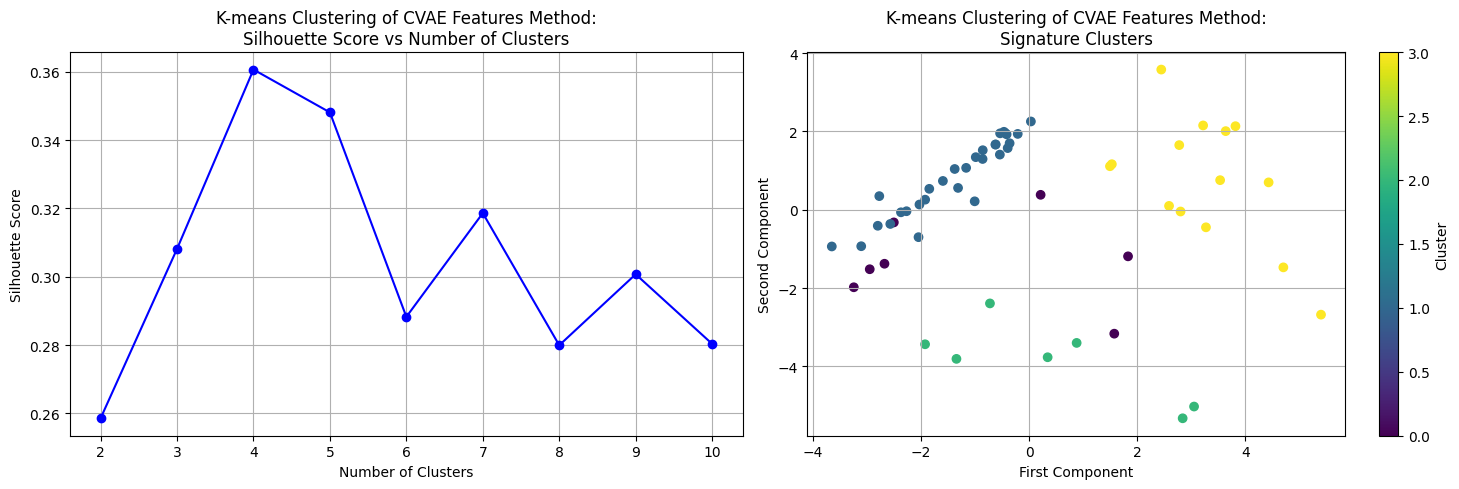

Detailed Cluster Analysis:


Cluster 1:
Number of samples: 30
Files in this cluster:
----------------
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
50
51
52
53
54
55
56
57
----------------


Cluster 3:
Number of samples: 14
Files in this cluster:
----------------
0
1
10
2
3
4
43
44
45
5
6
7
8
9
----------------


Cluster 2:
Number of samples: 7
Files in this cluster:
----------------
11
15
17
19
46
47
49
----------------


Cluster 0:
Number of samples: 7
Files in this cluster:
----------------
12
13
14
16
18
20
48
----------------


Detailed analysis has been saved to 'cluster_analysis.txt'


In [4]:
model_path = os.path.join(config['train_params']['task_name'], config['train_params']['ckpt_name'])

model = get_model(config).to(device)
model.load_state_dict(torch.load(model_path))

features, filenames = extract_features(model, dataloader, device)

max_clusters = 10
optimal_n_clusters, silhouette_scores = find_optimal_clusters(features, max_clusters)
print(f"\nOptimal number of clusters: {optimal_n_clusters}")

kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Create cluster mapping
clusters = defaultdict(list)
for filename, label in zip(filenames, cluster_labels):
    clusters[int(label)].append(filename)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plot_results(features_2d, cluster_labels, silhouette_scores, 
            'K-means Clustering of CVAE Features', 
            'Silhouette', start_n_clusters=2)

# Print cluster analysis
analyze_clusters(clusters)


In [ ]:
cluster_base_dir = os.path.join("data", "a_cluster")
source_dir = os.path.join("data", "a")

os.makedirs(cluster_base_dir, exist_ok=True)

for cluster_id, filenames in clusters.items():
    cluster_dir = os.path.join(cluster_base_dir, f"cluster_{cluster_id}")
    os.makedirs(cluster_dir, exist_ok=True)
    
    for filename in filenames:
        source_file = os.path.join(source_dir, f"{filename}.npy")
        dest_file = os.path.join(cluster_dir, f"{filename}.npy")
        shutil.copy2(source_file, dest_file)

print(f"Files have been organized into clusters in {cluster_base_dir}")

Files have been organized into clusters in data/a_cluster
